In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
df = pd.read_csv('./Resources/Cleaned_Datasets/monthly_trip.csv')
df

,startdate,Trip_number
0,2010-09-30,4002
1,2010-10-31,35957
2,2010-11-30,47390
3,2010-12-31,28248
4,2011-01-31,37503
...,...,...
123,2020-12-31,89908
124,2021-01-31,85219
125,2021-02-28,65289
126,2021-03-31,148833


In [3]:
df_2018= df[df['startdate'] <= '2019-01-31']
df_train= df_2018[df_2018['startdate'] <= '2016-12-31']
df_test= df_2018[df_2018['startdate'] >= '2016-12-31']
df_2018.iloc[75]

startdate      2016-12-31
Trip_number        168719
Name: 75, dtype: object

In [4]:
  
df_2018 = df_2018.rename(columns = {'startdate': 'Date', 'Trip_number': 'trip'})
df_2018.head()

,Date,trip
0,2010-09-30,4002
1,2010-10-31,35957
2,2010-11-30,47390
3,2010-12-31,28248
4,2011-01-31,37503


In [5]:
df_2018=df_2018.dropna()


In [6]:
df_2018.dtypes

Date    object
trip     int64
dtype: object

In [7]:
df_2018['Date'] = pd.to_datetime(df_2018['Date'])
df_2018.set_index('Date', inplace=True) #set date as index
df_2018.head()

,trip
Date,
2010-09-30,4002
2010-10-31,35957
2010-11-30,47390
2010-12-31,28248
2011-01-31,37503


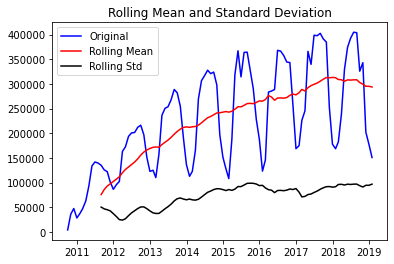

Results of dickey fuller test
Test Statistics                -5.109021
p-value                         0.000013
No. of lags used               11.000000
Number of observations used    89.000000
critical value (1%)            -3.506057
critical value (5%)            -2.894607
critical value (10%)           -2.584410
dtype: float64


In [8]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_2018)

<Figure size 432x288 with 0 Axes>

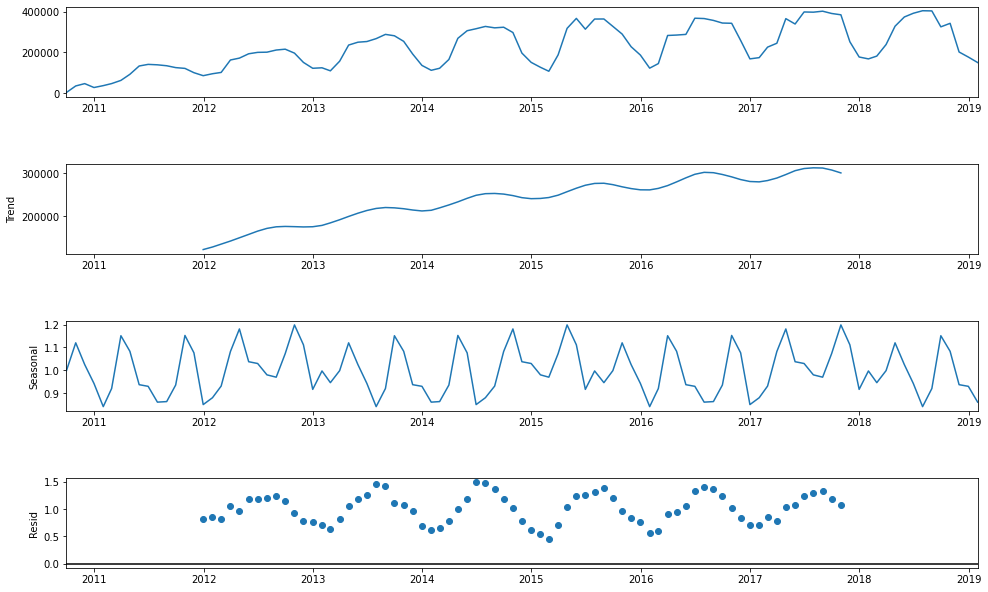

In [9]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_2018, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

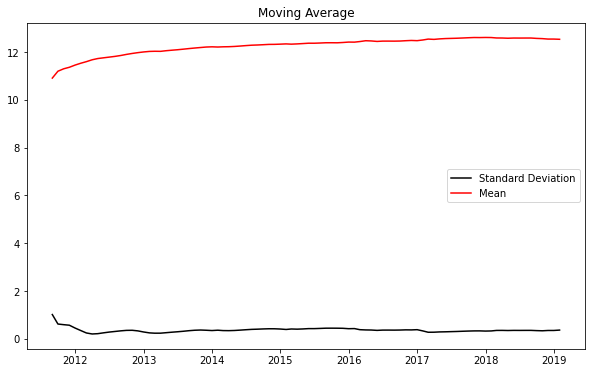

In [10]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_2018)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
#plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

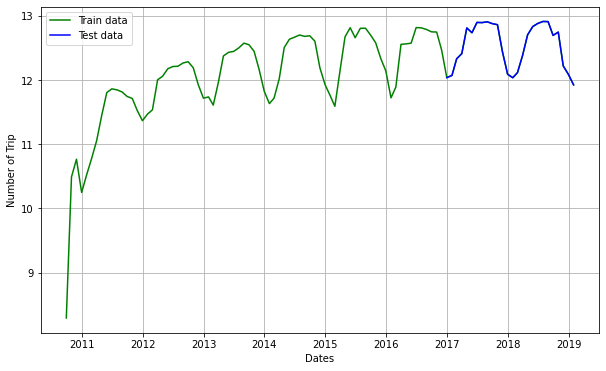

In [11]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.75)], df_log[int(len(df_log)*0.75):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Number of Trip')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=565.800, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-16.235, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-14.520, Time=0.20 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-12.240, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-21.986, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=51.006, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-0.106, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-21.775, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-20.885, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=122.962, Time=0.06 sec
 ARI

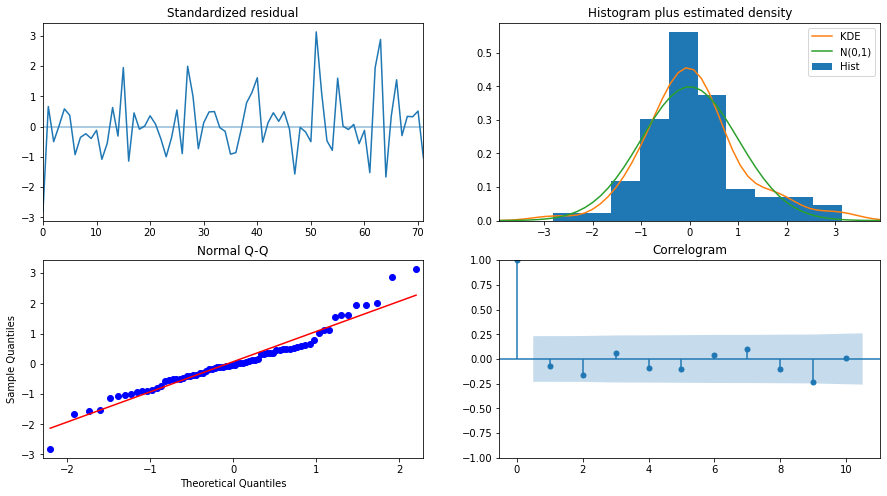

In [12]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [13]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(2,0,0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                              ARMA Model Results                              
Dep. Variable:                   trip   No. Observations:                   72
Model:                     ARMA(2, 0)   Log Likelihood                  15.332
Method:                       css-mle   S.D. of innovations              0.192
Date:                Sun, 01 Aug 2021   AIC                            -22.665
Time:                        22:25:17   BIC                            -13.558
Sample:                    12-31-2010   HQIC                           -19.039
                         - 11-30-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0339      0.199     60.610      0.000      11.645      12.423
ar.L1.trip     1.4666      0.099     14.825      0.000       1.273       1.661
ar.L2.trip    -0.5796      0.106     -5.444      0.0

C:\Users\Tikuyeh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [14]:
train_data


,trip
Date,
2010-12-31,10.248778
2011-01-31,10.532176
2011-02-28,10.769705
2011-03-31,11.053980
2011-04-30,11.441429
...,...
2016-07-31,12.811639
2016-08-31,12.786409
2016-09-30,12.749582


In [15]:
# Forecast
fc, se, conf = fitted.forecast(26, alpha=0.05)  # 95% conf

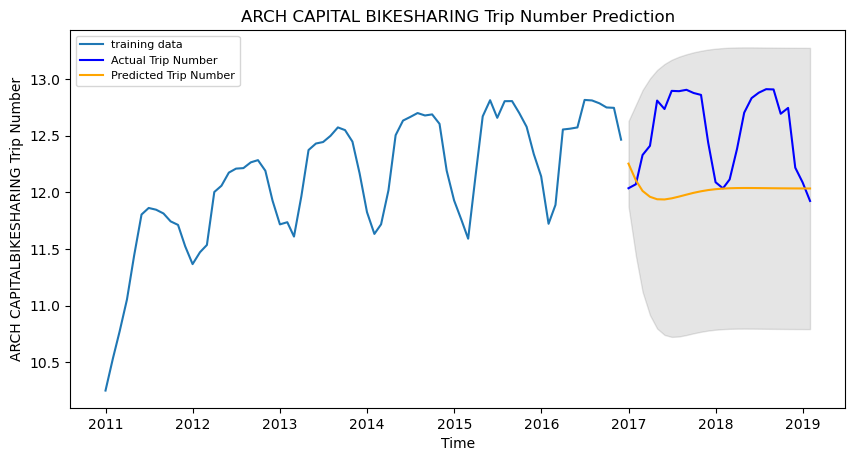

In [16]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Trip Number')
plt.plot(fc_series, color = 'orange',label='Predicted Trip Number')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL BIKESHARING Trip Number Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITALBIKESHARING Trip Number')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [17]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
#mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
#print('MAPE: '+str(mape))

MSE: 0.40313229300140807
MAE: 0.5347151844921595
RMSE: 0.6349269981670397
